## **Explainable AI in Time Series Data**

In [1]:
from pathlib import Path
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
print("PROJECT_ROOT:", PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))

PROJECT_ROOT: /Users/sarataboas/Desktop/master/ai_society/individual_assignment/socialCrisis_prediction


In [2]:
from src.models.train_utils import load_data, split_data, scale_data, create_time_windows
from src.explainability.explainability_utils import *

/Users/sarataboas/Desktop/master/ai_society/individual_assignment/socialCrisis_prediction/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
DATA_PATH   = PROJECT_ROOT / "datasets" / "data_merged.csv"
MODEL_PATH  = PROJECT_ROOT / "outputs" / "lstm_class_weights_model.h5"
SCALER_PATH = PROJECT_ROOT / "outputs" / "scaler_class_weights.save"

N_STEPS = 4
TARGET_COL = "label"


### **Experimental Setup**

In [4]:
df = load_data(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date') 

feature_names = [c for c in df.columns if c not in ["label"]]

print("N features:", len(feature_names))
print("Features:", feature_names)


N features: 11
Features: ['GDP_diff', 'UNRATE', 'CPI_diff', 'INDPRO_diff', 'DFF_diff', 'DGS10_diff', 'DGS2_diff', 'T10Y2Y', 'VIX', 'DTB3_diff', 'NEWS_SENTIMENT']


In [5]:
df_train, df_test = split_data(df, train_size=0.8)

print("Train rows:", len(df_train))
print("Test rows :", len(df_test))

Train rows: 113
Test rows : 29


In [6]:
df_train, df_test, scaler = scale_data(df_train, df_test, scaler_path=SCALER_PATH, target_col=TARGET_COL)

Scaler saved in /Users/sarataboas/Desktop/master/ai_society/individual_assignment/socialCrisis_prediction/outputs/scaler_class_weights.save


In [7]:
X_train, y_train = create_time_windows( df_train, n_steps=N_STEPS, target_col=TARGET_COL)
X_test, y_test = create_time_windows( df_test, n_steps=N_STEPS, target_col=TARGET_COL)
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

X_train: (109, 4, 11)
X_test : (25, 4, 11)


In [8]:
model = keras.models.load_model( MODEL_PATH, compile=False)
print("Model loaded")
print("Input shape :", model.input_shape)
print("Output shape:", model.output_shape)

Model loaded
Input shape : (None, 8, 11)
Output shape: (None, 1)


In [9]:
preds = model.predict(X_test, verbose=0)

preds = np.asarray(preds)
if preds.ndim == 1:
    preds = preds.reshape(-1, 1)

print("Preds shape:", preds.shape)
print("Preds min/max:", preds.min(), preds.max())

Preds shape: (25, 1)
Preds min/max: 0.21462286 0.55831474


In [10]:
threshold = 0.5
pred_labels = (preds[:, 0] > threshold).astype(int)

tp_idxs = np.where((y_test == 1) & (pred_labels == 1))[0]
fp_idxs = np.where((y_test == 0) & (pred_labels == 1))[0]
tn_idxs = np.where((y_test == 0) & (pred_labels == 0))[0]
fn_idxs = np.where((y_test == 1) & (pred_labels == 0))[0]

print(f"TP: {len(tp_idxs)} | FP: {len(fp_idxs)} | TN: {len(tn_idxs)} | FN: {len(fn_idxs)}")


instances = {
    "TP": int(tp_idxs[np.argmax(preds[tp_idxs, 0])]) if len(tp_idxs) > 0 else None,
    "FP": int(fp_idxs[np.argmax(preds[fp_idxs, 0])]) if len(fp_idxs) > 0 else None,
    "TN": int(tn_idxs[np.argmin(preds[tn_idxs, 0])]) if len(tn_idxs) > 0 else None,
    "FN": int(fn_idxs[np.argmax(preds[fn_idxs, 0])]) if len(fn_idxs) > 0 else None,
}

print("Selected instances:", instances)


TP: 2 | FP: 4 | TN: 19 | FN: 0
Selected instances: {'TP': 3, 'FP': 23, 'TN': 7, 'FN': None}


### **Integrated Gradients**

In [11]:
from alibi.explainers import IntegratedGradients

In [12]:
baseline = np.zeros_like(X_test[:1])
print(baseline.shape)

(1, 4, 11)


In [13]:
ig_explainer = IntegratedGradients(
    model,
    layer=None,       
    method="gausslegendre",
    n_steps=64        
)

In [14]:
idx = instances["TP"]   # ou FP / TN
x = X_test[idx:idx+1]

explanation = ig_explainer.explain(x, baselines=baseline, target=1)
ig_tp = explanation.attributions[0]   # shape (T, F)
ig_tp = ig_tp[0]   # agora (4, 11)


2026-01-04 16:48:36.937513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


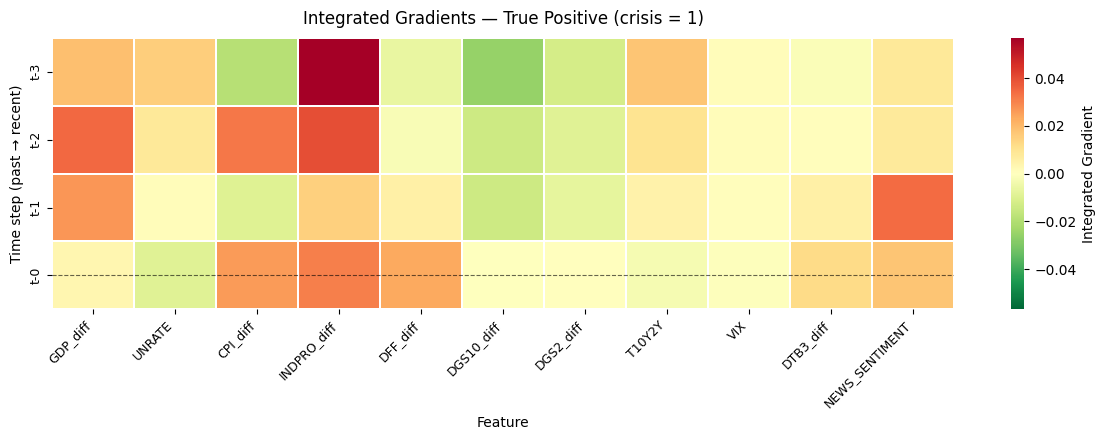

In [15]:
plot_ig_heatmap(ig_tp, feature_names, "Integrated Gradients — True Positive (crisis = 1)")

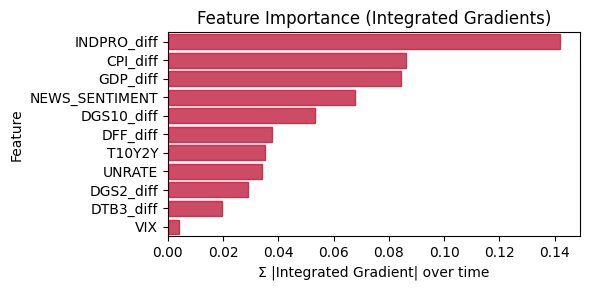

In [16]:
plot_ig_feature_importance(ig_tp, feature_names)

In [17]:
idx = instances["FP"]   # ou FP / TN
x = X_test[idx:idx+1]

explanation = ig_explainer.explain(x, baselines=baseline, target=1)
ig_fp = explanation.attributions[0]   # shape (T, F)
ig_fp = ig_fp[0]   # agora (4, 11)


2026-01-04 16:48:37.160381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


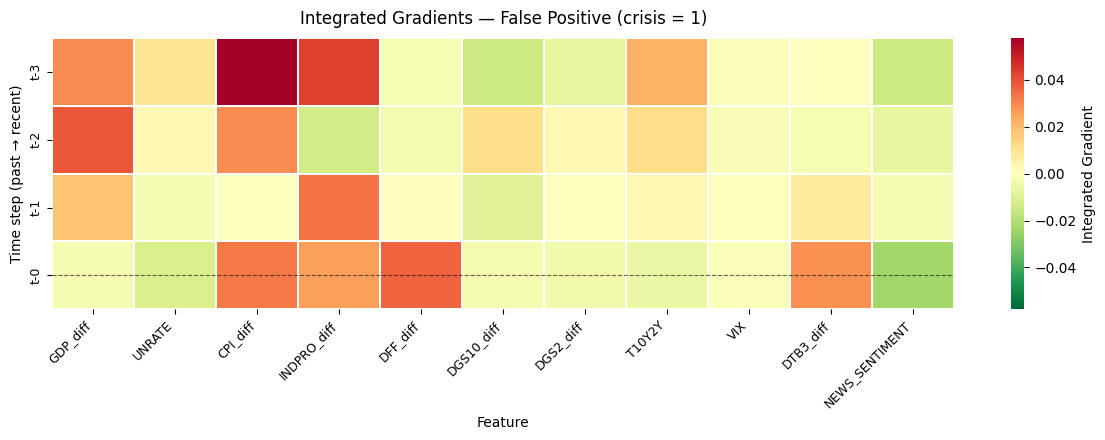

In [18]:
plot_ig_heatmap(ig_fp, feature_names, "Integrated Gradients — False Positive (crisis = 1)")

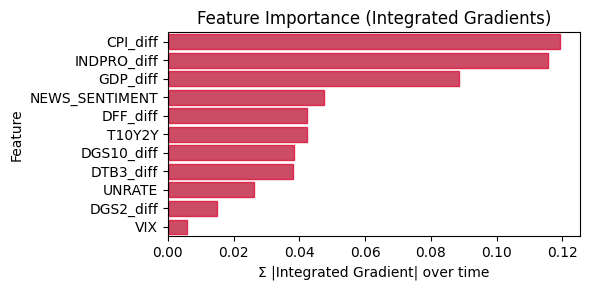

In [19]:
plot_ig_feature_importance(ig_fp, feature_names)

In [20]:
idx = instances["TN"]   # ou FP / TN
x = X_test[idx:idx+1]

explanation = ig_explainer.explain(x, baselines=baseline, target=0)
ig_tn = explanation.attributions[0]   # shape (T, F)
ig_tn = ig_tn[0]   # agora (4, 11)


2026-01-04 16:48:37.362248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


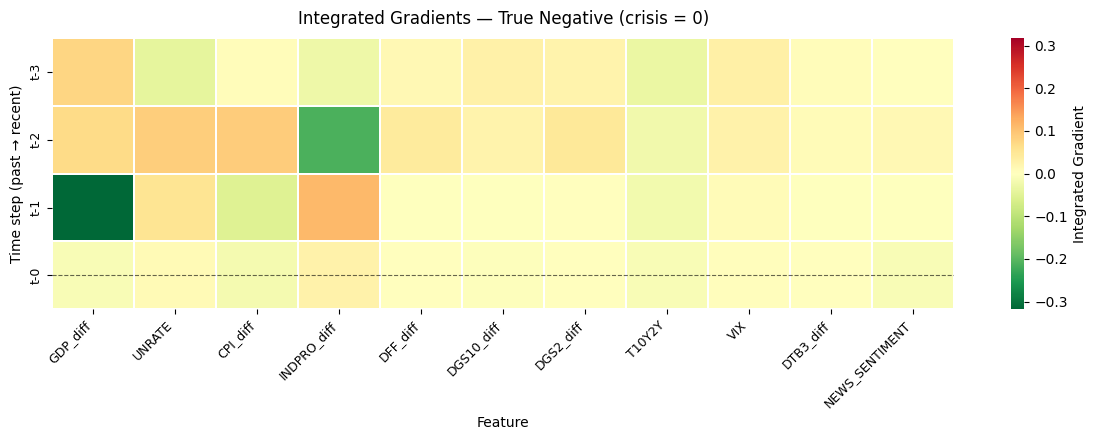

In [21]:
plot_ig_heatmap(ig_tn, feature_names, "Integrated Gradients — True Negative (crisis = 0)")

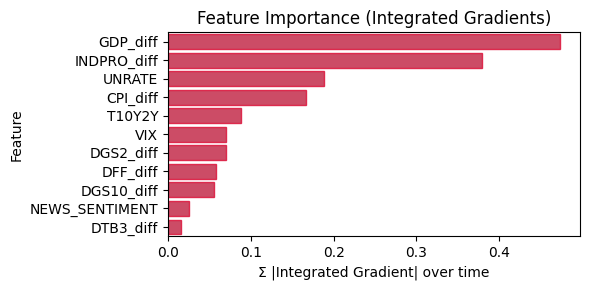

In [22]:
plot_ig_feature_importance(ig_tn, feature_names)

### **Occlusion-based Explainability**

In [23]:
idx = instances["TP"]   # ou FP / TN
x = X_test[idx:idx+1]
occlusion_map_tp = occlusion_feature_time(model, x)

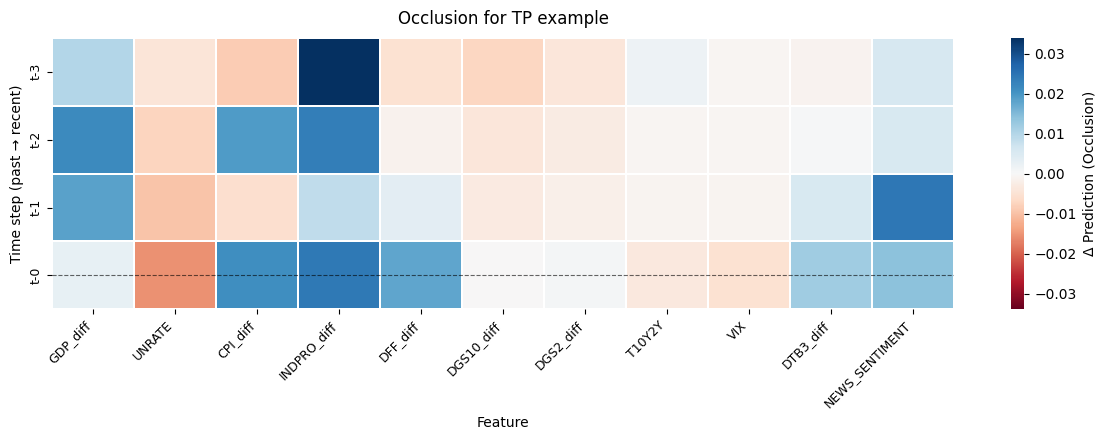

In [24]:
plot_occlusion_heatmap(occlusion_map_tp, feature_names, 'Occlusion for TP example')

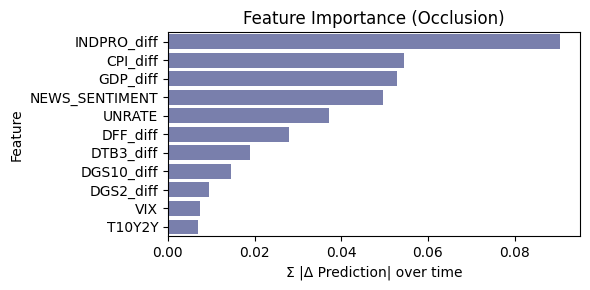

In [25]:
plot_occlusion_feature_importance(occlusion_map_tp, feature_names)

In [26]:
idx = instances["FP"]   # ou FP / TN
x = X_test[idx:idx+1]
occlusion_map_fp = occlusion_feature_time(model, x)

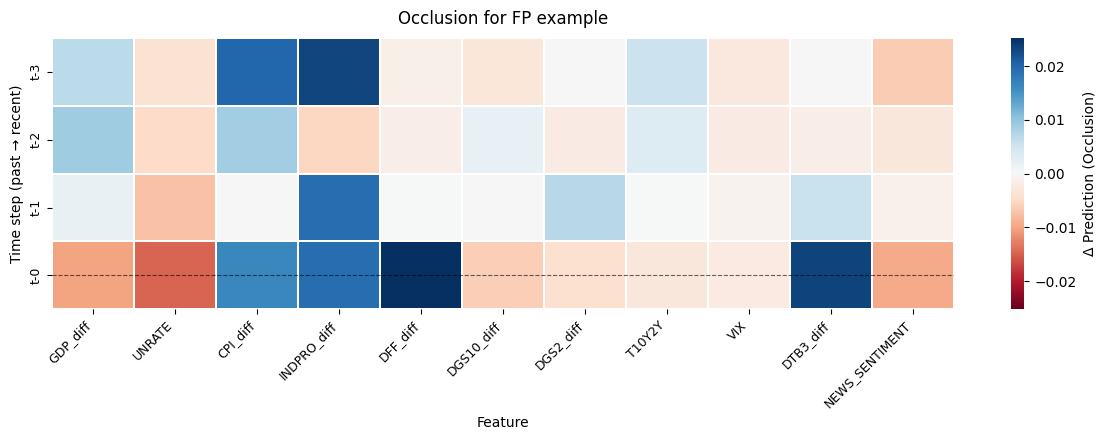

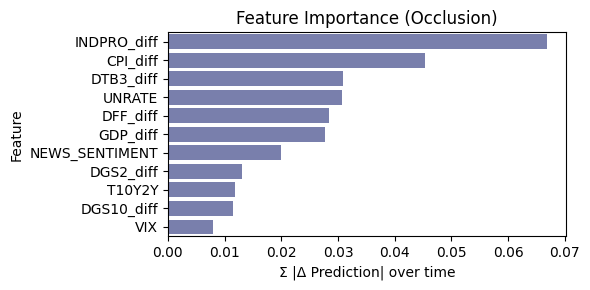

In [27]:
plot_occlusion_heatmap(occlusion_map_fp, feature_names, 'Occlusion for FP example')
plot_occlusion_feature_importance(occlusion_map_fp, feature_names)

In [28]:
idx = instances["TN"]   # ou FP / TN
x = X_test[idx:idx+1]
occlusion_map_tn = occlusion_feature_time(model, x)

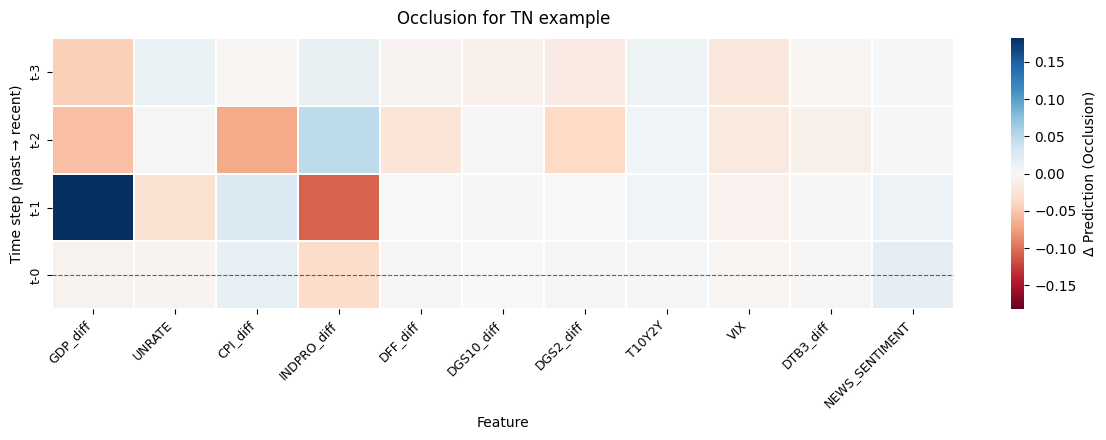

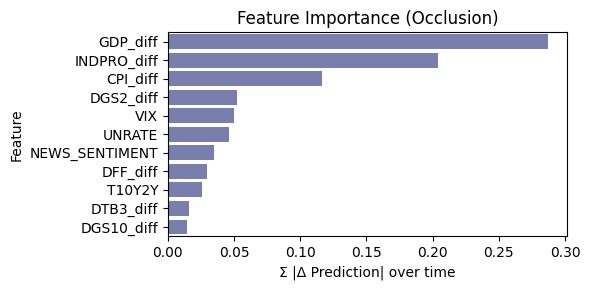

In [29]:
plot_occlusion_heatmap(occlusion_map_tn, feature_names, 'Occlusion for TN example')
plot_occlusion_feature_importance(occlusion_map_tn, feature_names)

### **LIME**

In [30]:
lime_feature_names = []
T, F = X_test.shape[1], X_test.shape[2]
for t in range(T):
    for f in feature_names:
        lime_feature_names.append(f"{f}@t-{T-1-t}")


In [31]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)

explainer = LimeTabularExplainer(
    X_train_flat,
    feature_names=lime_feature_names,
    class_names=["no_crisis", "crisis"],
    mode="classification",
    discretize_continuous=False
)


In [32]:
idx = instances["TP"]  # ou FP / TN
x_flat = X_test[idx].reshape(-1)

lime_exp = explainer.explain_instance(
    x_flat,
    lambda Z: lime_predict_fn(Z, X_test, model),
    num_features=10,
    top_labels=1
)


In [33]:
df_lime = lime_to_dataframe(lime_exp, label=1)
df_lime


,feature,weight,abs_weight
0,INDPRO_diff@t-3,-0.034407,0.034407
1,INDPRO_diff@t-2,-0.032098,0.032098
2,T10Y2Y@t-3,-0.032088,0.032088
3,CPI_diff@t-2,0.029780,0.029780
4,UNRATE@t-3,-0.026318,0.026318
5,DGS10_diff@t-3,0.025540,0.025540
6,UNRATE@t-2,-0.023897,0.023897
7,T10Y2Y@t-2,-0.022134,0.022134
8,UNRATE@t-1,-0.017436,0.017436
9,GDP_diff@t-2,0.016337,0.016337


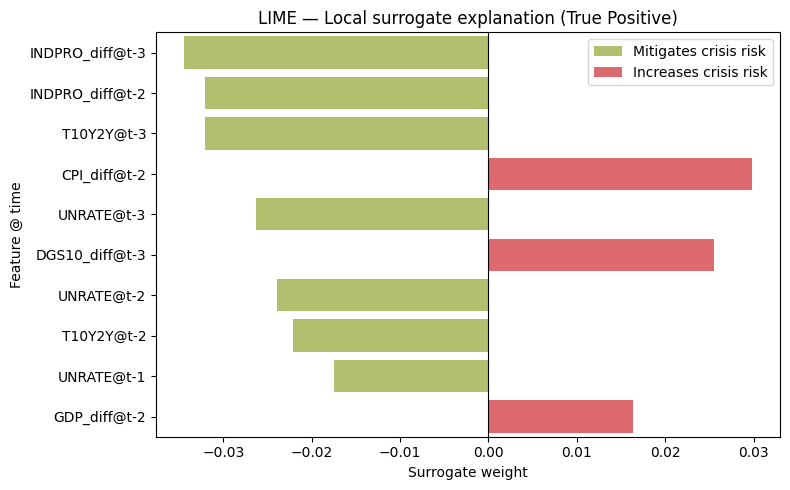

In [34]:
plot_lime_surrogate(
    df_lime,
    title="LIME — Local surrogate explanation (True Positive)",
    max_features=10
)


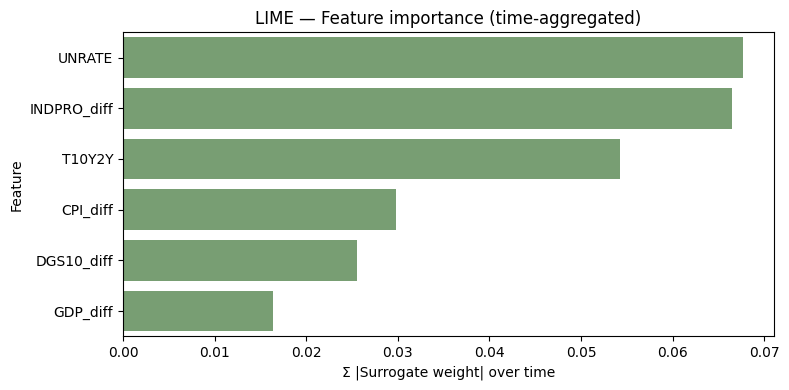

In [35]:
plot_lime_by_feature(df_lime)

----

## Statistical Explanability

In this work, the task consists of anticipating periods of social and economic crisis using time-series indicators.
Given this objective, not all classification errors have the same practical or societal impact.

In particular:

   - False Negatives (FN) correspond to situations where the model predicts a normal period while a crisis is actually occurring.`

Formally:

- y_true = 1 (crisis)
- y_pred = 0 (non-crisis)


In social and policy-making contexts, this error type represents a failure of anticipation, meaning that early warning signals are not detected in time, potentially preventing adequate preparation or response.

For this reason, our analysis focuses specifically on False Negatives, as they represent the most critical failure mode of the system.

FN = False Negatives: the model predicts a normal period when there is a crisis label

We are interested in anticipating crisis, therefore we focused our analysis in the FN error type. In social conditions, this error means lack of response and anticipation capacity.

**Goal Question:** Under which statistical conditions does the model fail to anticipate crisis? Are False Negatives associated with significant shifts in the statistical distribution of the input data compared to normal (non-crisis) periods? 

**In what type of data regime does the model stop being reliable?**



**How to do this:**

Traditional XAI methods explain model decisions at the instance level. However crisis are systemic phenomena, aften associated with structural changes in data distributions, rather than isolated feature values. Therefore, we introduced a form of statistical explainability, aiming to:

- Characterize distributional shifts over time
- Relate those shifts to model failures
- Understand model robustness under regime change

Em que regime estatístico é que o modelo falha.

In [36]:
from pathlib import Path
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
print("PROJECT_ROOT:", PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))

PROJECT_ROOT: /Users/sarataboas/Desktop/master/ai_society/individual_assignment/socialCrisis_prediction


In [37]:
from src.explainability.shift_model_analysis import *

In [38]:
N_STEPS = 4
target_col = "label"

X, y = create_time_windows(df, n_steps=N_STEPS, target_col=target_col)
dates = window_dates_from_index(df.index, N_STEPS)
feature_names = [c for c in df.columns if c != target_col]
print(X.shape, y.shape, len(dates))

(138, 4, 11) (138,) 138


In [39]:
# windows temporais 
X_train, y_train = create_time_windows(df_train, n_steps=N_STEPS)
dates_train = window_dates_from_index(df_train.index, n_steps=N_STEPS)
X_test, y_test = create_time_windows(df_test, n_steps=N_STEPS)
dates_test = window_dates_from_index(df_test.index, n_steps=N_STEPS)

# baseline vem do TRAIN (importante!)
baseline_data = make_baseline_data(X_train, y_train) # baseline is computed from non-crisis training windows to avoid information leakage

In [40]:
H = 4
y_early = make_early_labels(y, horizon=H)

In [41]:
stats_df = compute_shift_over_time(
    X=X,
    y_true=y,
    y_early=y_early,
    dates=dates,
    baseline_data=baseline_data
)

stats_df.head()


,y_true,y_early,shift_global
date,,,
1991-01-01,1,0,0.776339
1991-04-01,0,0,0.915975
1991-07-01,0,0,1.006247
1991-10-01,0,0,0.935678
1992-01-01,0,0,0.957997


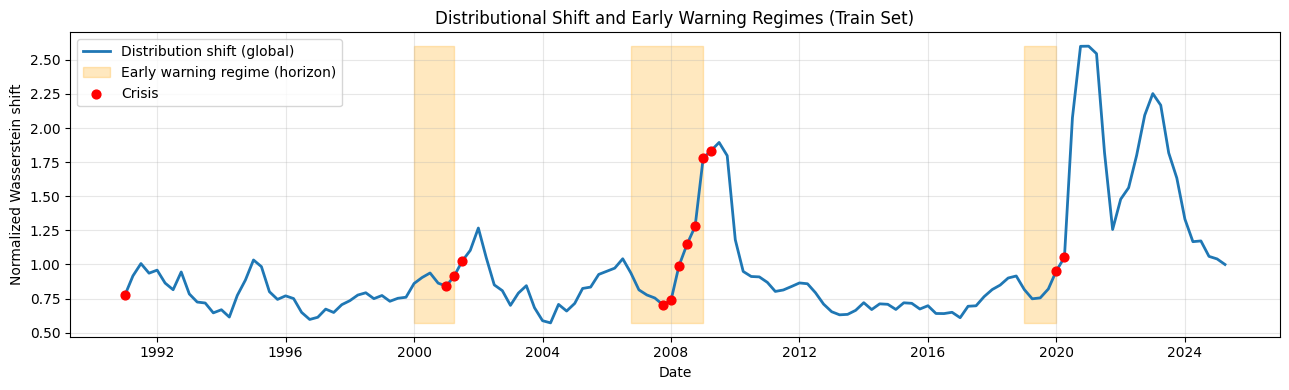

In [42]:
plot_global_shift_with_early_warning(
    stats_df,
    title="Distributional Shift and Early Warning Regimes (Train Set)"
)

In [52]:
H = 4
y_early = make_early_labels(y_test, horizon=H)
stats_df_test = compute_shift_over_time(
    X=X_test,
    y_true=y_test,
    y_early=y,
    dates=dates_test,
    baseline_data=baseline_data
)

stats_df_test.head()


,y_true,y_early,shift_global
date,,,
2019-04-01,0,1,0.747708
2019-07-01,0,0,0.754515
2019-10-01,0,0,0.819909
2020-01-01,1,0,0.954641
2020-04-01,1,0,1.051298


In [ ]:
y_pred, y_proba = get_model_predictions(model, X)
fn_mask = get_false_negatives(y, y_pred)

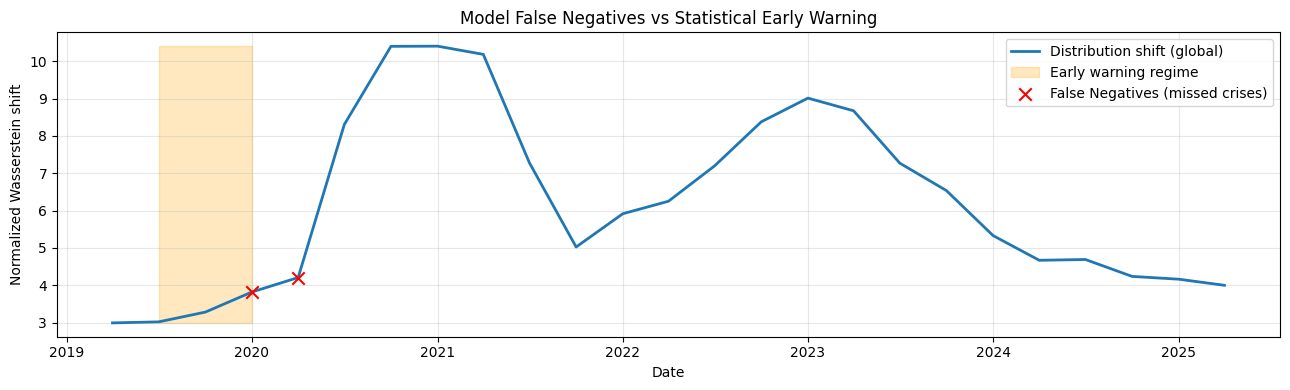

In [61]:
plot_fn_with_early_warning(
    stats_df,
    fn_mask,
    title="Model False Negatives vs Statistical Early Warning"
)